# Modeling - After Hyperparameter

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Modeling 
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report


In [3]:
dataset = pd.read_csv('dataclear.csv')

In [4]:
# Memisahkan data menjadi fitur (X) dan label (y)
X = dataset.drop(columns=['TARGET'], axis = 1)
y = dataset['TARGET']


print('X data shape: ', X.shape)
print('y data shape: ', y.shape)

X data shape:  (307507, 129)
y data shape:  (307507,)


In [5]:
# Dataset di seimbangkan dengan cara RandomOverSampling minoruty
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
X, y = ros.fit_resample(X, y)
print('X data shape after oversampling: ', X.shape)
print('y data shape after oversampling: ', y.shape)

X data shape after oversampling:  (565364, 129)
y data shape after oversampling:  (565364,)


In [6]:
y.value_counts()

1    282682
0    282682
Name: TARGET, dtype: int64

In [7]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mencetak bentuk data X_train, X_test, y_train, dan y_test
print('X_train data shape: ', X_train.shape)
print('y_train data shape: ', y_train.shape)
print('X_test data shape: ', X_test.shape)
print('y_test data shape: ', y_test.shape)

X_train data shape:  (452291, 129)
y_train data shape:  (452291,)
X_test data shape:  (113073, 129)
y_test data shape:  (113073,)


## KNN

In [8]:
# Create model
m5 = "K-NeighborsClassifier"
knn = KNeighborsClassifier(n_neighbors=10, weights="distance" , algorithm="auto", leaf_size=40, metric="minkowski")
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# Evaluate model performance
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confusion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))


confusion matrix
[[36136 20213]
 [    2 56722]]


Accuracy of K-NeighborsClassifier: 82.12216886436197 

              precision    recall  f1-score   support

           0       1.00      0.64      0.78     56349
           1       0.74      1.00      0.85     56724

    accuracy                           0.82    113073
   macro avg       0.87      0.82      0.82    113073
weighted avg       0.87      0.82      0.82    113073



## Extreme Gradient Boost

In [9]:
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))

confussion matrix
[[46335 10014]
 [ 5427 51297]]


Accuracy of Extreme Gradient Boost: 86.3442201055955 

              precision    recall  f1-score   support

           0       0.90      0.82      0.86     56349
           1       0.84      0.90      0.87     56724

    accuracy                           0.86    113073
   macro avg       0.87      0.86      0.86    113073
weighted avg       0.87      0.86      0.86    113073



## Lightgbm

In [10]:
# dataframe to hold predictions
test_predictions = np.zeros(X_test.shape[0])
# dataframe for out of fold validation predictions
out_of_fold = np.zeros(X_train.shape[0])
# lists for validation and training scores
valid_scores = []
train_scores = []

In [11]:
k_fold = KFold(n_splits = 4, shuffle = True, random_state = 50)

In [12]:
X_train = X_train.drop(columns=['SK_ID_CURR'], axis = 1)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=18)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)


In [14]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 4500, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=170, verbose_eval=200)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.501806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 170 rounds
[200]	valid_0's auc: 0.770113
[400]	valid_0's auc: 0.7897
[600]	valid_0's auc: 0.80253
[800]	valid_0's auc: 0.811985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's auc: 0.849105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3200]	valid_0's auc: 0.873604
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4400]	valid_0's auc: 0.893002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

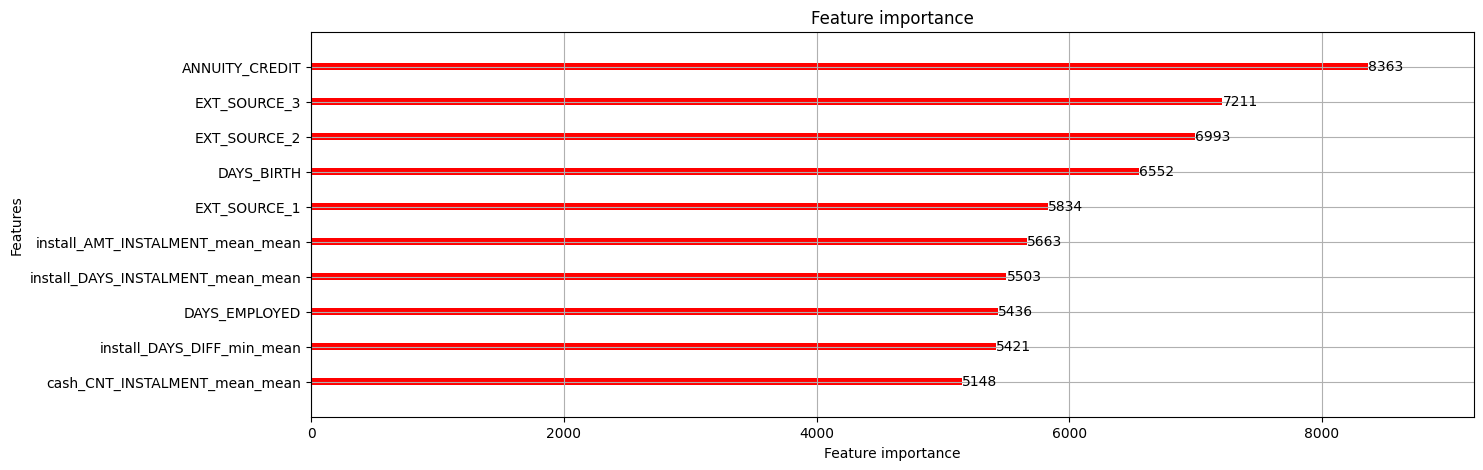

In [15]:
lgb.plot_importance(model, max_num_features=10, figsize=(15,5),color="red")

# Predict Results

In [16]:
sub = X_test[['SK_ID_CURR']]
X_test = X_test.drop('SK_ID_CURR',axis = 1)
preds = model.predict(X_test)
sub['TARGET'] = preds

In [17]:
X_test['SK_ID_CURR'] = sub['SK_ID_CURR']

In [18]:
sub.head()

,SK_ID_CURR,TARGET
425667,341858,0.915236
242358,380568,0.476008
483725,134127,0.301440
130526,251397,0.748307
21983,125608,0.401502


In [19]:
sub = sub.merge(X_test, on = 'SK_ID_CURR', how = 'left')

In [20]:
# membuat fungsi mapping
def mapping(value):
  if 0 <= value <= 0.25:
    return 'Engage them'
  elif 0.26 <= value <= 0.5:
    return 'Almost gone'
  elif 0.51 <= value <= 0.75:
    return 'Need to Attention'
  elif 0.76 <= value <= 1:
    return 'Unhealthy Customer'
  else:
    return 'Invalid value'

# menerapkan fungsi mapping ke kolom dataframe
sub['TARGET'] = sub['TARGET'].apply(lambda x: mapping(x))

In [21]:
# menampilkan dataframe hasil
sub.head()

,SK_ID_CURR,TARGET,DAYS_EMPLOYED,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,install_AMT_DIFF_max_mean,install_AMT_DIFF_min_mean,cash_MONTHS_BALANCE_count_mean,cash_CNT_INSTALMENT_mean_mean,cash_SK_DPD_mean_mean,cash_SK_DPD_DEF_mean_mean,NAME_CONTRACT_STATUS_Approved_mean_y,NAME_CONTRACT_STATUS_Completed_mean_y,NAME_CONTRACT_STATUS_Returnedtothestore_mean,NAME_CONTRACT_STATUS_Signed_mean
0,341858,Unhealthy Customer,-230,1,0,1,0,157500.0,586377.0,47011.5,...,0.000,0.0,7.0,6.000000,0.0,0.0,0.0,1.0,0.0,0.0
1,341858,Unhealthy Customer,-230,1,0,1,0,157500.0,586377.0,47011.5,...,0.000,0.0,7.0,6.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,341858,Unhealthy Customer,-230,1,0,1,0,157500.0,586377.0,47011.5,...,0.000,0.0,7.0,6.000000,0.0,0.0,0.0,1.0,0.0,0.0
3,380568,Almost gone,-974,1,1,1,1,270000.0,497520.0,32521.5,...,0.000,0.0,23.0,23.826087,0.0,0.0,0.0,1.0,0.0,0.0
4,134127,Almost gone,-4380,1,0,1,2,112500.0,180000.0,9000.0,...,10030.995,0.0,13.0,12.000000,0.0,0.0,0.0,1.0,0.0,0.0


Sum of TARGET => 241845


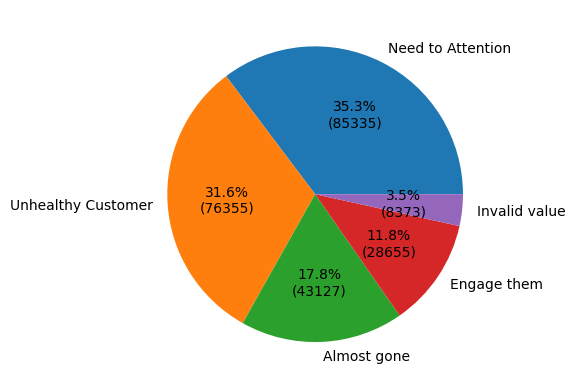

In [22]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format


# Sum of species 
sum_sp = sub.TARGET.value_counts().values.sum()

s = sub.TARGET.value_counts()
plt.pie(s,labels = s.index, autopct=autopct_format(s))
print("Sum of TARGET => {}".format(sum_sp))

